# PC Session 5

# **Optimal Policy Learning**

**Authors:**
Jonathan Chassot, [Helge Liebert](https://hliebert.github.io/), and [Anthony Strittmatter](http://www.anthonystrittmatter.com)

We test how donors respond to new information about a charity’s effectiveness. Freedom from Hunger implemented a test of its direct marketing solicitations, varying letters by whether they include a discussion of their program's impact as measured by scientific research. The base script, used for both treatment and control, included a standard qualitative story about an individual beneficiary. The allocation of the ''scientific mailer'' is randomised.

Reference: [Karlan and Wood (2017)](https://www.sciencedirect.com/science/article/pii/S2214804316300490)

Variable list:


+ **char_giving**: Amount of gifts in response to mail
+ **treat**: Mailer includes a discussion about the program impact as measured by scientific research


+ **amount_pre**: Amount given before specified mailer
+ **amount_lastpre**: Amount of last gift before specified mailer
+ **amount_maxpre**: Largest gift before specified mailer
+ **H_number_yearbefore**: \# of gifts given in year prior to experiment
+ **H_ngifts**: Number of gifts given over donor's giving history before mailer
+ **H_littleask**: Received mailer with small ask string-small donor in past
+ **H_bigask**: Received mailer with big ask string-big donor in past
+ **H_nyears**: Number of years donor is in database before specified mailer
+ **H_frequency**: Number of gifts per year (that donor was in donor database before specified mail
+ **H_medinc**: Median zip code income
+ **H_medinc_mdum**: Dummy to reflect replacement to 0 when missing
+ **H_Avg_years_ed**: Average years of education in census tract
+ **H_Avg_years_ed_mdum**: Dummy to reflect replacement to 0 when missing


We want is to find policy rules for allocating the ''scientific letter'' that can increase future gift amounts.

## Load Packages

In [1]:
########################  Load Packages  ########################

# List of required packages
pkgs <- c('fBasics', 'corrplot', 'psych', 'glmnet', 'glmnetUtils', 'devtools', 'rpart',
          'rpart.plot', 'tidyverse', 'grf', 'reshape2', 'caret', 'plotmo')

# Load packages
for(pkg in pkgs){
    library(pkg, character.only = TRUE)
}

print('All packages successfully installed and loaded.')

Loading required package: timeDate
Loading required package: timeSeries
corrplot 0.84 loaded

Attaching package: ‘psych’

The following object is masked from ‘package:fBasics’:

    tr

The following object is masked from ‘package:timeSeries’:

    outlier

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: ‘glmnetUtils’

The following objects are masked from ‘package:glmnet’:

    cv.glmnet, glmnet

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()      masks psych::%+%()
✖ purrr::accumulate() masks foreach::accumulate()
✖ ggplot2::alpha()    masks psych::alpha()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks timeSeries::filter(), sta

[1] "All packages successfully installed and loaded."


## Load Data

In [2]:
########################  Load Data Frame  ########################
set.seed(100239) # set starting value for random number generator

# Load data frame
df <- read.csv("Data/fundraising.csv",header=TRUE, sep=",")

# Outcome Variable
outcome <- c("char_giving")

# Treatment Variables
treatment <- c("treat")

# Covariates/Features
covariates <- c("amount_pre", "amount_lastpre", "amount_maxpre", "H_number_yearbefore", "H_ngifts",
                "H_littleask", "H_bigask", "H_nyears", "H_frequency", "H_medinc", "H_medinc_mdum",
                "H_Avg_years_ed", "H_Avg_years_ed_mdum")

    
all_variables <- c(outcome, treatment, covariates)

print('Data frame successfully loaded and sample selected.')

[1] "Data frame successfully loaded and sample selected."


## Desriptive Statistics

#### Mean and Standard Deviations

In [3]:
########################  Table with Descriptive Statistics  ########################
desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
  select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=2))

# Print as tex-file
#kable(desc, "latex", booktabs = T)

                        Mean    Stdev Minimum   Maximum  nobs
char_giving            14.94   267.05    0.00  30000.00 23122
treat                   0.50     0.50    0.00      1.00 23122
amount_pre            320.90  1137.65    1.00  62849.99 23122
amount_lastpre         50.79   266.59    1.00  25707.36 23122
amount_maxpre          71.27   353.36    1.00  25707.36 23122
H_number_yearbefore     0.74     1.16    0.00     21.00 23122
H_ngifts                6.97    11.58    1.00    261.00 23122
H_littleask             0.88     0.33    0.00      1.00 23122
H_bigask                0.12     0.33    0.00      1.00 23122
H_nyears                7.35     7.08    1.00     54.00 23122
H_frequency             0.86     0.83    0.08     10.50 23122
H_medinc            52056.29 24061.48    0.00 200001.00 23122
H_medinc_mdum           0.03     0.18    0.00      1.00 23122
H_Avg_years_ed         14.00     2.98    0.00     21.05 23122
H_Avg_years_ed_mdum     0.03     0.18    0.00      1.00 23122


The outcome variable *char_giving* is highly right-skewed. 

### Corrleations

png 
  2

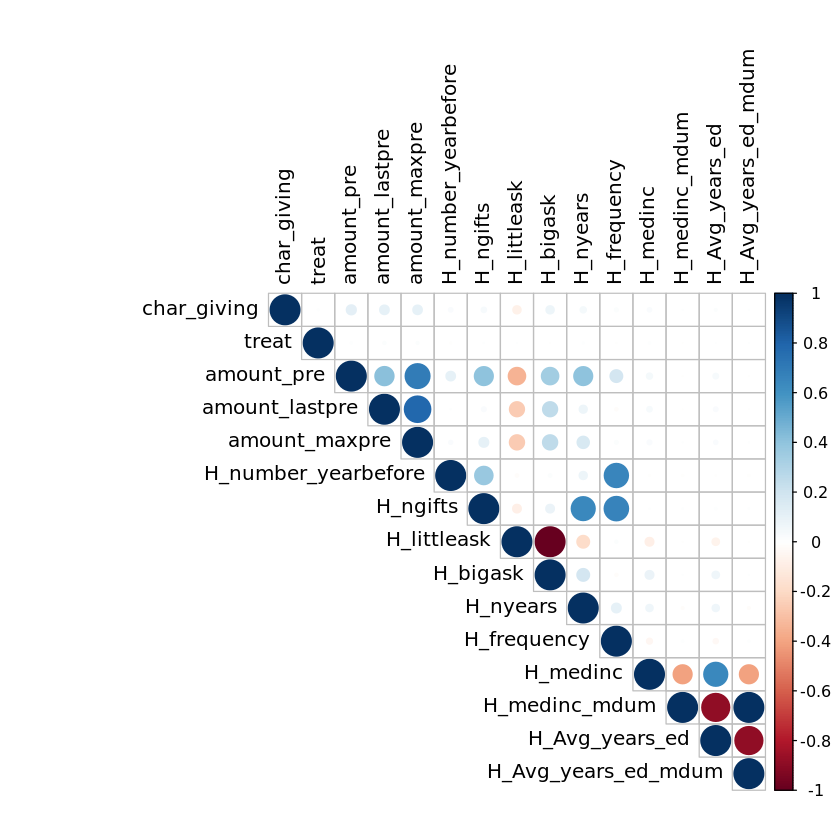

In [4]:
########################  Correlation Matrix  ########################

corr = cor(df)
corrplot(corr, type = "upper", tl.col = "black")

# Save correlation matrix as png-file
png(height=1200, width=1200, file="correlation.png")
    corrplot(corr, type = "upper", tl.col = "black")
dev.off()

The sum of past givings (*amount_pre*) is highly correleted with several other covariates.

# Prepare Data

In [5]:
########################  Extract Dataset  ########################

# Extracting Data 
data <- df %>% dplyr::select(all_variables)

# Setting up the data, renaming columns and discarding rows with NA (if any)
df <- bind_cols(data) %>%  na.omit()

print('Data successfully extracted.')

########################  Partition the Samples  ########################

# Partition Hold-Out-Sample
df_part <- modelr::resample_partition(df, c(obs = 0.8, hold_out = 0.2))
df_obs <- as.data.frame(df_part$obs) # Training and estimation sample
df_hold_out <- as.data.frame(df_part$hold_out) # Hold-out-sample

# Partition Samples for Cross-Fitting
df_part <- modelr::resample_partition(df_obs, c(obs_A = 0.5, obs_B = 0.5))
df_obs_A <- as.data.frame(df_part$obs_A) # Sample A
df_obs_B <- as.data.frame(df_part$obs_B) # Sample B

print('Samples are partitioned.')

########################  Generate Variables  ########################

# Outcome
giving_hold_out <- as.matrix(df_hold_out[,1])
giving_obs <- as.matrix(df_obs[,1])
giving_obs_A <- as.matrix(df_obs_A[,1])
giving_obs_B <- as.matrix(df_obs_B[,1])

# Treatment
treat_hold_out <- as.matrix(df_hold_out[,2])
treat_obs <- as.matrix(df_obs[,2])
treat_obs_A <- as.matrix(df_obs_A[,2])
treat_obs_B <- as.matrix(df_obs_B[,2])

# Covariates
covariates_hold_out <- as.matrix(df_hold_out[,c(3:ncol(df_hold_out))])
covariates_obs <- as.matrix(df_obs[,c(3:ncol(df_obs))])
covariates_obs_A <- as.matrix(df_obs_A[,c(3:ncol(df_obs_A))])
covariates_obs_B <- as.matrix(df_obs_B[,c(3:ncol(df_obs_B))])

########################  Standardise Covariates  ########################

preProcValues <- preProcess(covariates_obs, method = c("center", "scale"))
covariates_hold_out <- predict(preProcValues, covariates_hold_out) 
covariates_obs <- predict(preProcValues, covariates_obs) 
covariates_obs_A <- predict(preProcValues, covariates_obs_A) 
covariates_obs_B <- predict(preProcValues, covariates_obs_B) 

df_obs <- as.data.frame(cbind(giving_obs,treat_obs,covariates_obs))
df_obs_A <- as.data.frame(cbind(giving_obs_A,treat_obs_A,covariates_obs_A))
df_obs_B <- as.data.frame(cbind(giving_obs_B,treat_obs_B,covariates_obs_B))

print('Covariates are standardised.')
print('The data is now ready for your analysis!')

[1] "Data successfully extracted."
[1] "Samples are partitioned."
[1] "Covariates are standardised."
[1] "The data is now ready for your analysis!"


# Nuisance Parameters

We use generalised random forests (*grf-package*) to predict the outcome ([Athey, Tibshirani, Wager, 2018](https://arxiv.org/abs/1610.01271)).

## Potential Outcomes

In [6]:
########################  Potential Outcomes  ######################## 
set.seed(100244)

# Tuning parameters
min_tree = 20
# Number of trees is set to a very low value in order to increase the computational speed in this tutorial
num_trees = 100 # Use at least 1,000 trees
cov_frac = 2/3
sample_part= 0.5

# Build generalised random forest
# Hoensty is automatically implemented

# Use Sample A to predict Sample B
# Potential outcome under treatment
f_y1_A <- regression_forest(covariates_obs_A[treat_obs_A == 1,], giving_obs_A[treat_obs_A == 1, ],
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
y1hat_B <- predict(f_y1_A, covariates_obs_B)$predictions

# Potential outcome under non-treatment
f_y0_A <- regression_forest(covariates_obs_A[treat_obs_A == 0,], giving_obs_A[treat_obs_A == 0, ],
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
y0hat_B <- predict(f_y0_A, covariates_obs_B)$predictions

# Use Sample B to predict Sample A
# Potential outcome under treatment
f_y1_B <- regression_forest(covariates_obs_B[treat_obs_B == 1,], giving_obs_B[treat_obs_B == 1, ],
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
y1hat_A <- predict(f_y1_B, covariates_obs_A)$predictions

# Potential outcome under non-treatment
f_y0_B <- regression_forest(covariates_obs_B[treat_obs_B == 0,], giving_obs_B[treat_obs_B == 0, ],
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
y0hat_A <- predict(f_y0_B, covariates_obs_A)$predictions

print("Potential outcomes are estimated")

[1] "Potential outcomes are estimated"


## Propensity Score

In [7]:
########################  Propensity Score  ######################## 
set.seed(100243)

# Tuning parameters
min_tree = 20
num_trees = 100 # Use at least 1,000 trees
cov_frac = 2/3
sample_part= 0.5

# Use Sample A to predict Sample B
f_p_A <- regression_forest(covariates_obs_A, treat_obs_A,
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
pscore_B <- predict(f_p_A, covariates_obs_B)$predictions

# Use Sample B to predict Sample A
f_p_B <- regression_forest(covariates_obs_B, treat_obs_B,
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
pscore_A <- predict(f_p_B, covariates_obs_A)$predictions

print("Propensity scores are estimated")

[1] "Propensity scores are estimated"


# Average Effects

We use the double machine learning approach to estimate ATEs.

In [8]:
########################  Average Treatment Effects (ATE)  ########################

# Generate Modified Outcome
Y_star_A = invisible(y1hat_A - y0hat_A + treat_obs_A*(giving_obs_A - y1hat_A)/pscore_A 
            - (1-treat_obs_A)*(giving_obs_A - y0hat_A)/(1-pscore_A))

Y_star_B = invisible(y1hat_B - y0hat_B + treat_obs_B*(giving_obs_B - y1hat_B)/pscore_B 
            - (1-treat_obs_B)*(giving_obs_B - y0hat_B)/(1-pscore_B))

Y_star = invisible(0.5*(mean(Y_star_A) + mean(Y_star_B)))

# Average Treatment Effect (ATE)
ATE <- round(Y_star, digits=1)
print(paste0("Average Treatment Effect (ATE): ", ATE))
print(paste0("Median ATE: ", round(0.5*(median(Y_star_A) + median(Y_star_B)),digits=2)))
# Outcome variable is highly right-skewed. We have to be careful when interpeting mean effects.
# Median effects are more approriate

# Standard error
SD_ATE <- round(sqrt(0.5*(var(Y_star_A) + (mean(Y_star_A) - Y_star)^2)/nrow(Y_star_A) 
                     + 0.5*(var(Y_star_B) + (mean(Y_star_B) - Y_star)^2)/nrow(Y_star_B)),digits=1)
print(paste0("Standard Error for ATE: ", SD_ATE))

# Variance estimator (more) robust to outliers
var_A <-(quantile(Y_star_A,pnorm(1, mean = 0, sd = 1)) - quantile(Y_star_A,pnorm(-1, mean = 0, sd = 1)))/2
var_B <-(quantile(Y_star_B,pnorm(1, mean = 0, sd = 1)) - quantile(Y_star_B,pnorm(-1, mean = 0, sd = 1)))/2
SD_ATE <- round(sqrt(0.5*(var_A^2 + (mean(Y_star_A) - Y_star)^2)/nrow(Y_star_A) 
                     + 0.5*(var_B^2 + (mean(Y_star_B) - Y_star)^2)/nrow(Y_star_B)),digits=1)
print(paste0("Outlier Robust Standard Error for ATE: ", SD_ATE))

# Compare results with OLS on full sample
ols <- lm(formula = char_giving ~ treat, data = df)
summary(ols)

[1] "Average Treatment Effect (ATE): 2.5"
[1] "Median ATE: -0.27"
[1] "Standard Error for ATE: 6.3"
[1] "Outlier Robust Standard Error for ATE: 0.3"



Call:
lm(formula = char_giving ~ treat, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
  -16.5   -16.5   -13.4   -13.4 29983.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   13.411      2.481   5.406 6.51e-08 ***
treat          3.060      3.512   0.871    0.384    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 267 on 23120 degrees of freedom
Multiple R-squared:  3.283e-05,	Adjusted R-squared:  -1.042e-05 
F-statistic: 0.7591 on 1 and 23120 DF,  p-value: 0.3836


# Conditional Average Treatment Effects

We use a generalised random forest to identify systematic effect heterogeneity in the orthogonal score (*Y_star*). 

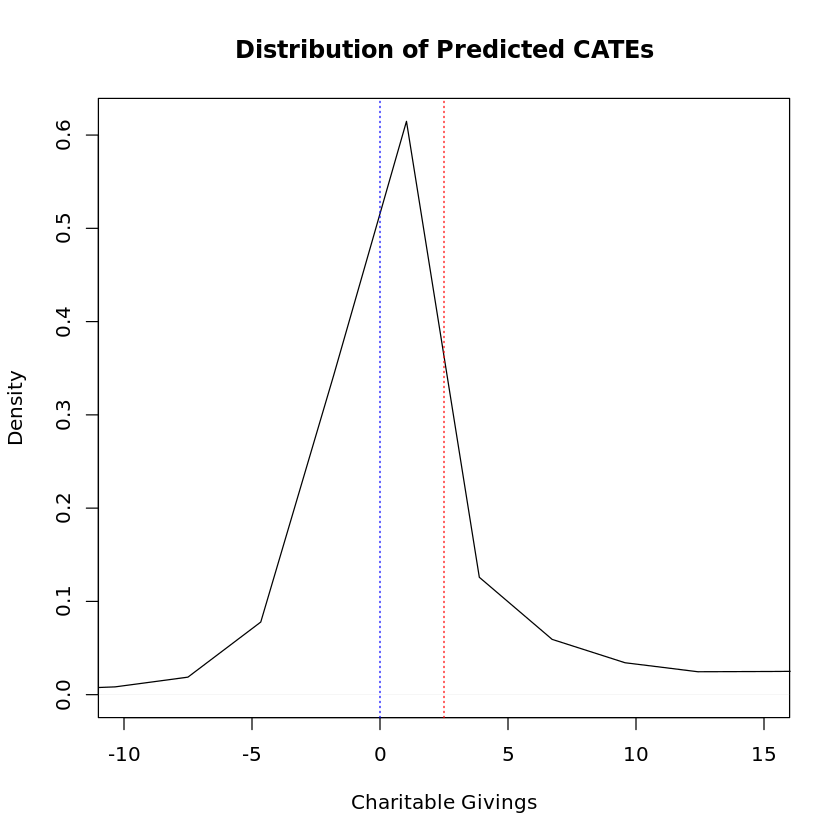

In [9]:
########################  Conditional Average Treatment Effects (CATE)  ########################
set.seed(100234)

# Tuning parameters
min_tree = 20
num_trees = 100 # Use at least 1,000 trees
cov_frac = 2/3
sample_part= 0.5

# Using Sample A 
f_cate1_A <- regression_forest(covariates_obs_A, Y_star_A,
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
cate1_hat_A <- predict(f_cate1_A, covariates_obs)$predictions
cate1_hat_A_hold_out <- predict(f_cate1_A, covariates_hold_out)$predictions

## Using Sample B 
f_cate1_B <- regression_forest(covariates_obs_B, Y_star_B,
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
cate1_hat_B <- predict(f_cate1_B, covariates_obs)$predictions
cate1_hat_B_hold_out <- predict(f_cate1_B, covariates_hold_out)$predictions

# Merge estimates from both samples
cate1_hat = 0.5*(cate1_hat_A + cate1_hat_B)
cate1_hold_out = 0.5*(cate1_hat_A_hold_out + cate1_hat_B_hold_out) # Out-of-sample preddiction

########################  Plot Distribution of Predicted CATEs  ########################

d1 <- density(cate1_hat)
plot(d1, main="Distribution of Predicted CATEs", xlim=c(-10, 15), xlab = "Charitable Givings")
abline(v=c(0,ATE), col=c("blue", "red"), lty=c(3,3), lwd=c(1, 1))
legend(-40,.25, legend=c("MOM"), lty=c(1), cex=0.8)


We plot the quartiles of the pedicted CATEs.

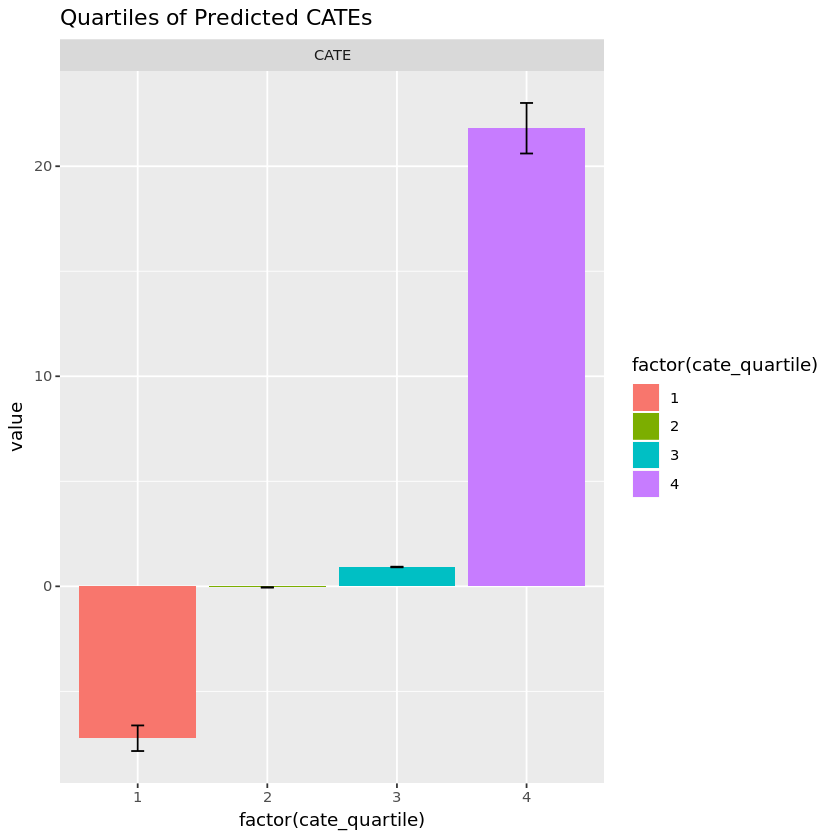

In [10]:
########################  Quartiles of Predicted CATEs  ########################
# Code based on Athey and Imbens, 2018, AEA lecture

cate1 <- as.data.frame(cate1_hat)
colnames(cate1) <- "CATE"
mom_quartile <- cate1 %>%
            dplyr::select(c("CATE")) %>%
            dplyr::mutate(cate_quartile = ntile(cate1, n=4))

m <- mom_quartile %>% group_by(cate_quartile) %>% summarize_all(mean) %>% melt(id="cate_quartile")
s <- mom_quartile %>% group_by(cate_quartile) %>% summarize_all(~sqrt(var(.)/(length(.)-1))) %>% melt(id="cate_quartile")
limits <- aes(ymax = m[,"value"] + 1.96*s[,"value"], ymin=m[,"value"] - 1.96*s[,"value"])

m %>% ggplot(aes(x=factor(cate_quartile), y=value)) +
      facet_wrap(~variable, nrow = 2) + 
      geom_bar(aes(fill=factor(cate_quartile)), stat="identity") +
      geom_errorbar(limits, width=.1) + 
      ggtitle("Quartiles of Predicted CATEs") 

We plot average covariate values by quartile of predicted CATEs.

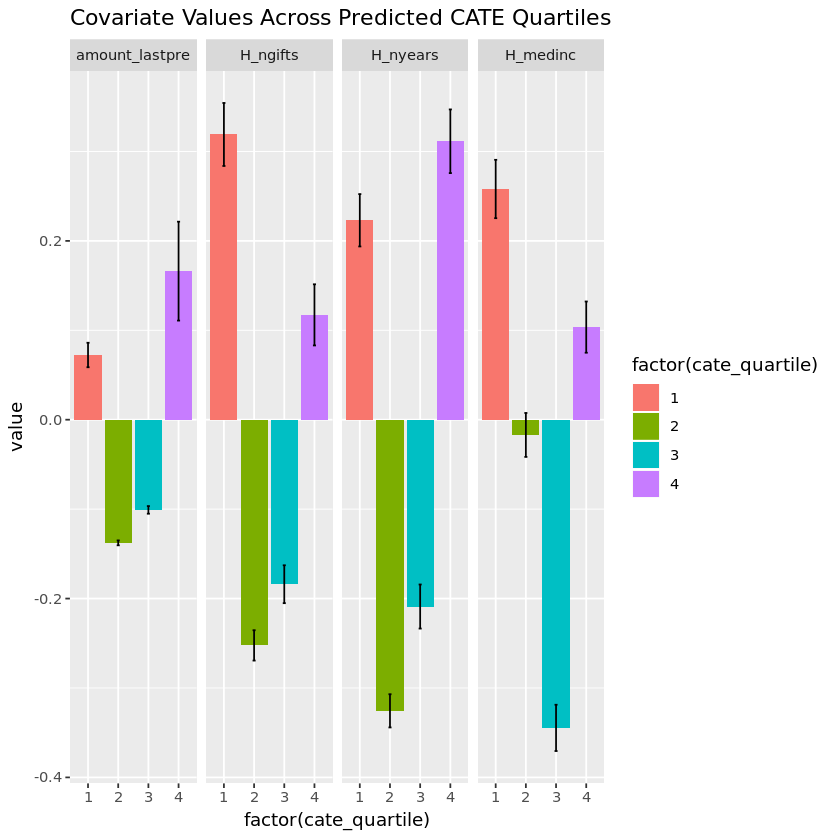

In [11]:
########################  Covariate Values Across Predicted CATE Quartiles  ########################
# Code based on Athey and Imbens, 2018, AEA lecture

mom2_quartile <- df_obs %>%
            dplyr::select(c("amount_lastpre", "H_ngifts", "H_nyears", "H_medinc")) %>%
            dplyr::mutate(cate_quartile = ntile(cate1, n=4))

m <- mom2_quartile %>% group_by(cate_quartile) %>% summarize_all(mean) %>% melt(id="cate_quartile")
s <- mom2_quartile %>% group_by(cate_quartile) %>% summarize_all(~sqrt(var(.)/(length(.)-1))) %>% melt(id="cate_quartile")
limits <- aes(ymax = m[,"value"] + 1.96*s[,"value"], ymin=m[,"value"] - 1.96*s[,"value"])

m %>% ggplot(aes(x=factor(cate_quartile), y=value)) +
      facet_wrap(~variable, nrow = 1) + 
      geom_bar(aes(fill=factor(cate_quartile)), stat="identity") +
      geom_errorbar(limits, width=.1) + 
      ggtitle("Covariate Values Across Predicted CATE Quartiles") 

# Probability of Charitable Giving

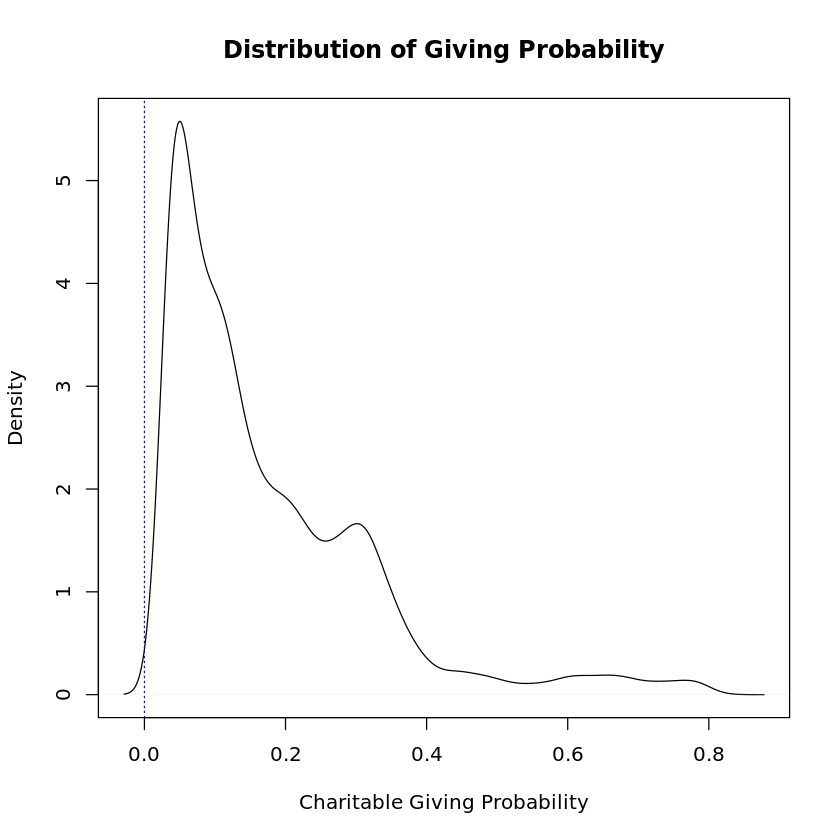

In [12]:
########################  Probability of Charitable Giving  ########################
set.seed(100235)

# Tuning parameters
min_tree = 20
num_trees = 100 # Use at least 1,000 trees
cov_frac = 2/3
sample_part= 0.5

# Generate Dummy for Positive Charitable Giving
giving_ind_obs <- as.numeric(giving_obs > 0)

# Generalised Random Forest
f_gprob <- regression_forest(covariates_obs, giving_ind_obs,
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
gprob <- predict(f_gprob, covariates_obs)$predictions
gprob_hold_out <- predict(f_gprob, covariates_hold_out)$predictions

########################  Plot Distribution of Giving Probability  ########################

d2 <- density(gprob)
plot(d2, main="Distribution of Giving Probability",  xlab = "Charitable Giving Probability")
abline(v=c(0), col=c("blue"), lty=c(3), lwd=c(1))
legend(-40,.25, legend=c("Giving Probability"), lty=c(1), cex=0.8)

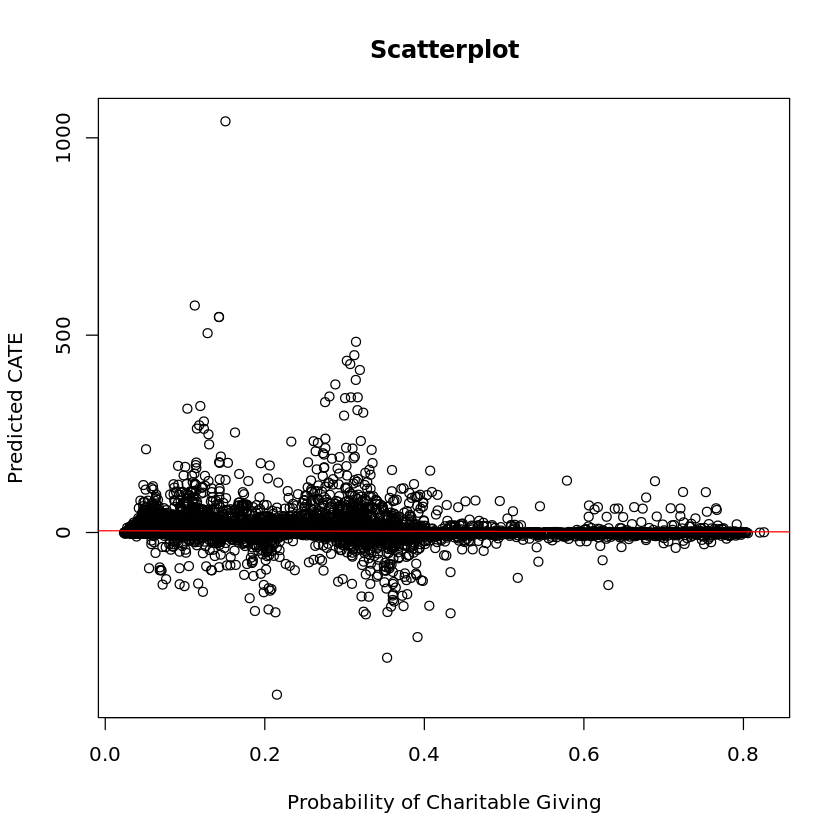

In [13]:
########################  Scatter Plot of CATE and Giving Probability  ########################

plot(gprob, cate1_hat, main="Scatterplot",
   xlab="Probability of Charitable Giving", ylab="Predicted CATE", pch = 1)
abline(lm(cate1_hat~gprob), col="red") # regression line (y~x)

# Individualised Treatment Rules Using Shallow Trees

We estimate individualised treatment rules (ITR) using the approach proposed in [Athey and Wager (2018)](https://arxiv.org/abs/1702.02896).

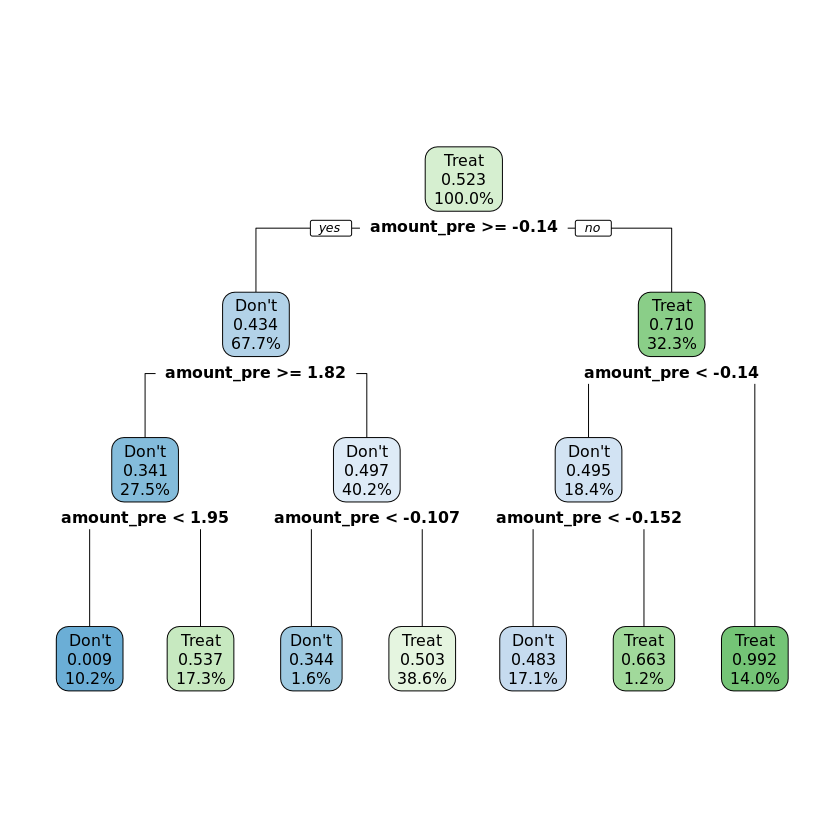

In [14]:
########################  Individualised Treatment Rules  ########################                         
# Code based on Athey and Imbens, 2018, AEA lecture
set.seed(100233)

# Define transformed Variables
sign_A = sign(Y_star_A)
lambda_A = abs(Y_star_A)
sign_B = sign(Y_star_B)
lambda_B = abs(Y_star_B)
Z_A <- factor(sign_A, labels = c("Don't", "Treat"))
Z_B <- factor(sign_B, labels = c("Don't", "Treat"))

########################  Build a Shallow Tree  ########################                         

# Tree Sample A
tree_1_A <- rpart(formula = str_c("Z_A ~ ", covariates), # Predict sign of treatment
                data = df_obs_A,
                weights = lambda_A,  # Larger effect --> Higher weight
                method = "class",
                control = rpart.control(cp = 0.00000000000002, maxdepth = 3))

# Tree Sample B
tree_1_B <- rpart(formula = str_c("Z_B ~ ", covariates), # Predict sign of treatment
                data = df_obs_B,
                weights = lambda_B,  # Larger effect --> Higher weight
                method = "class",
                control = rpart.control(cp = 0.00000000000002, maxdepth = 3))

# Plot MSE in CV-Sample
rpart.plot(tree_1_A,digits=3)

# Predict policy rule to hold-out-sample
covariates_hold_out <- as.data.frame(covariates_hold_out)
pred_tree1_hold_out_A <- as.matrix(predict(tree_1_A, newdata=covariates_hold_out))
pred_tree1_hold_out_B <- as.matrix(predict(tree_1_A, newdata=covariates_hold_out))
pi_tree1_hold_out = 0.5*(pred_tree1_hold_out_A[,2]+ pred_tree1_hold_out_B[,2])


##  Built Deeper Trees

[1] "Optimal number of splits: 13"
[1] "Optimal number of splits: 1"


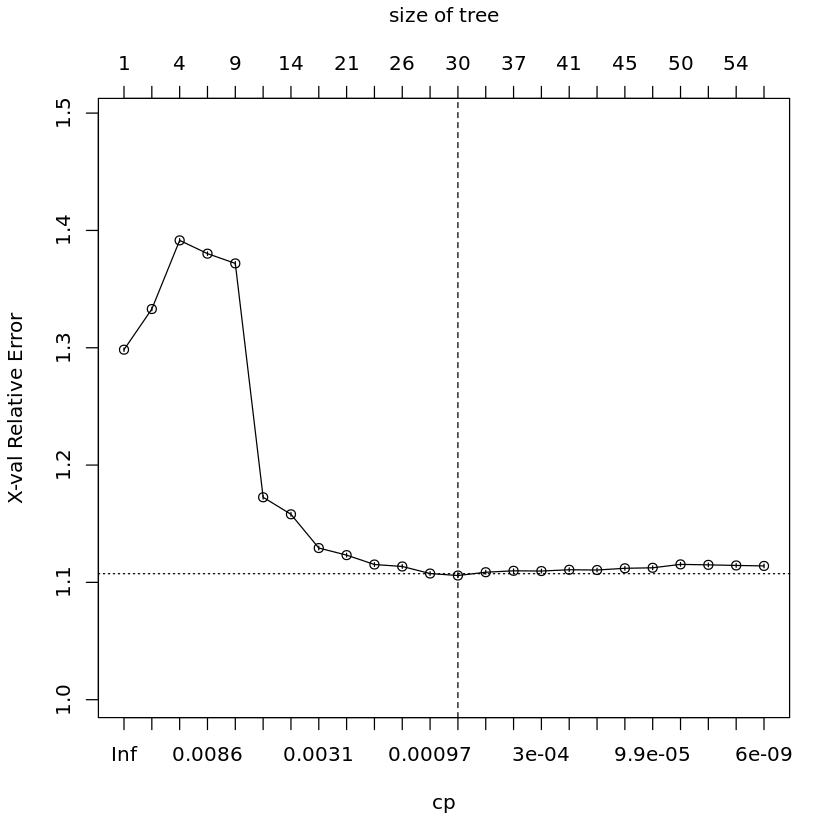

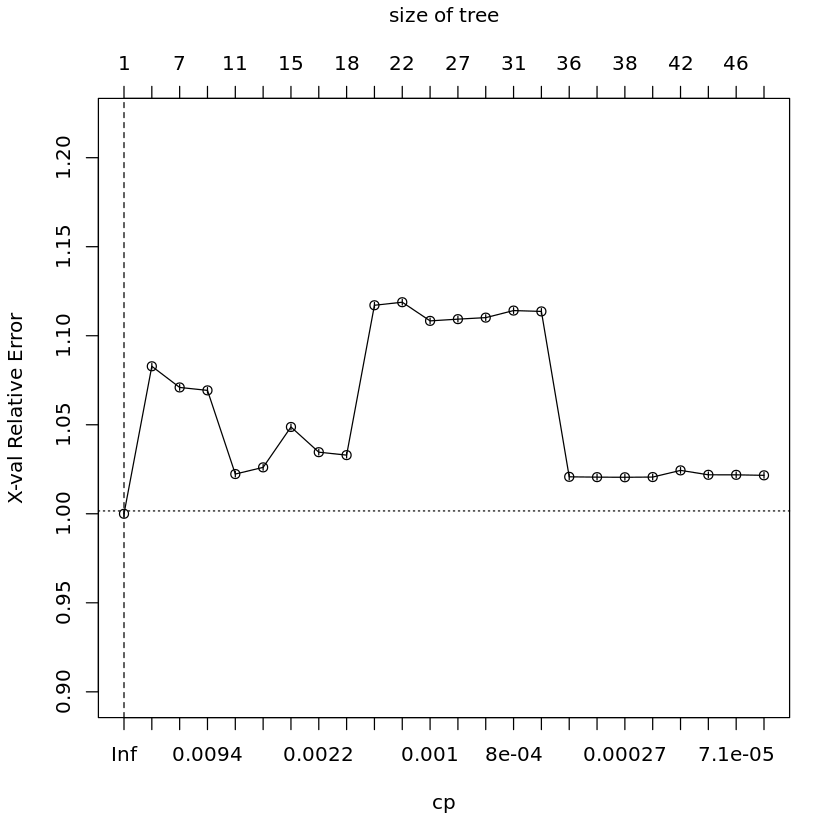

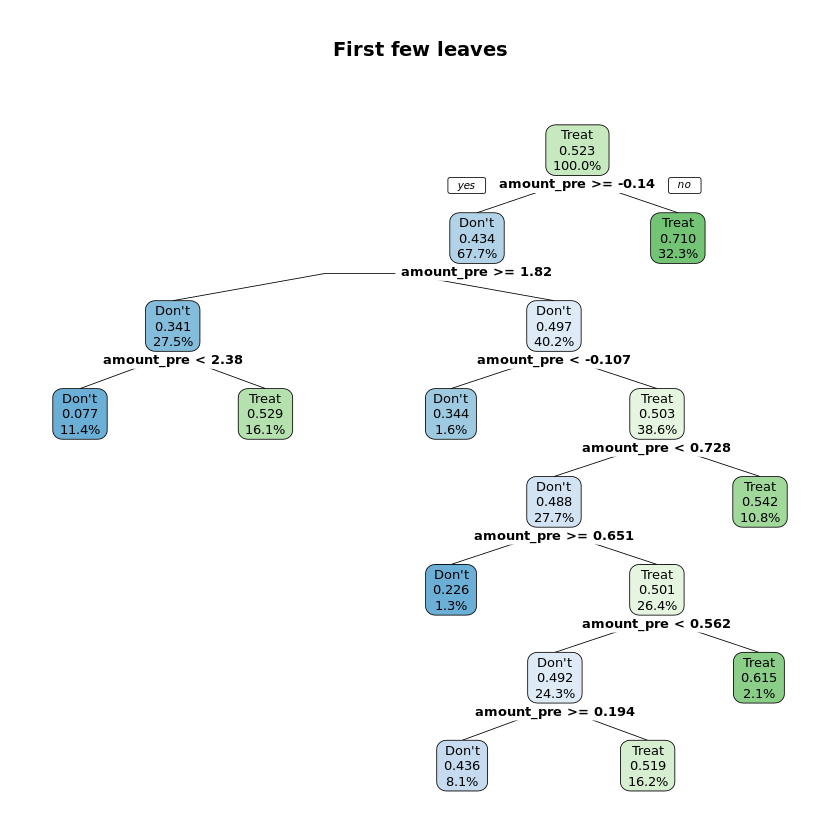

In [15]:
########################  Build Trees Deeper Tree  ########################                         
## Note: Asymptotic results hold only for trees with little complexity
set.seed(100235)

# Tree Sample A
tree_2_A <- rpart(formula = str_c("Z_A ~ ", covariates), # Predict sign of treatment
                data = df_obs_A,
                weights = lambda_A,  # Larger effect --> Higher weight
                method = "class",
                control = rpart.control(cp = 0.000000000002, minbucket=50))
# Tree Sample B
tree_2_B <- rpart(formula = str_c("Z_B ~ ", covariates), # Predict sign of treatment
                data = df_obs_B,
                weights = lambda_B,  # Larger effect --> Higher weight
                method = "class",
                control = rpart.control(cp = 0.000000000002, minbucket=50))

# Find optimal tree sizes
op.index_2_A <- which.min(tree_2_A$cptable[, "xerror"])
print(paste0("Optimal number of splits: ", op.index_2_A))
op.index_2_B <- which.min(tree_2_B$cptable[, "xerror"])
print(paste0("Optimal number of splits: ", op.index_2_B))

# Plot CV-MSE in Samples A and B
plotcp(tree_2_A, minline = TRUE)
abline(v = op.index_2_A, lty = "dashed")
plotcp(tree_2_B, minline = TRUE)
abline(v = op.index_2_B, lty = "dashed")

########################  Select the Tree that Minimises CV-MSE  ######################## 

# Get cp-value that corresponds to optimal tree sizes
cp.vals_2_A <- tree_2_B$cptable[op.index_2_A, "CP"]
cp.vals_2_B <- tree_2_B$cptable[op.index_2_B, "CP"]

# Prune the trees
prune_tree_2_A <- prune(tree_2_A, cp = cp.vals_2_A)
prune_tree_2_B <- prune(tree_2_B, cp = cp.vals_2_B)

# Plot the first few leaves of tree A
prune_tree_short <- prune(tree_2_A, cp = tree_2_A$cptable[5, "CP"])
rpart.plot(prune_tree_short,digits=3, main = "First few leaves",fallen.leaves=FALSE)

# Predict policy rule to hold-out-sample
pred_tree2_hold_out_A <- as.matrix(predict(tree_2_A, newdata=covariates_hold_out))
pred_tree2_hold_out_B <- as.matrix(predict(tree_2_A, newdata=covariates_hold_out))
pi_tree2_hold_out = 0.5*(pred_tree2_hold_out_A[,2]+ pred_tree2_hold_out_B[,2])

# Out-of-Sample Comparison

Now we go out-of-sample and compare four possible policy rules:

1. Send ''scientific mailer'' to individuals with a low charity probability. 
2. Send ''scientific mailer'' to individuals with a positive CATE.
3. Send ''scientific mailer'' to individuals selected by the individualised treatment rule based on the shallow tree (ITR1).
4. Send ''scientific mailer'' to individuals selected by the individualised treatment rule based on the deeper tree (ITR2).

In [16]:
########################  Out-of-Sample Comparison  ######################## 

# Probability rule 
rule_gprob <- as.numeric(gprob_hold_out < mean(gprob_hold_out)) # we set threshold at average giving probability
# CATE rule
rule_cate <- as.numeric(cate1_hold_out> 0)
# Rule based on shallow tree (ITR1)
rule_tree_1 <- as.numeric(pi_tree1_hold_out> .5)
# Rule based on deeper tree (ITR2)
rule_tree_2 <- as.numeric(pi_tree2_hold_out > .5)
                  
print('Descriptives of Policy Rules')
desc <- fBasics::basicStats(cbind(rule_gprob,rule_cate,rule_tree_1,rule_tree_2)) %>% t() %>% as.data.frame() %>% 
  select(Mean, nobs)
print(round(desc, digits=2))

print('Correlation between the Policy Rules')
corr = cor(cbind(rule_gprob,rule_cate,rule_tree_1,rule_tree_2))
print(corr)


[1] "Descriptives of Policy Rules"
            Mean nobs
rule_gprob  0.62 4625
rule_cate   0.61 4625
rule_tree_1 0.30 4625
rule_tree_2 0.46 4625
[1] "Correlation between the Policy Rules"
             rule_gprob   rule_cate rule_tree_1 rule_tree_2
rule_gprob   1.00000000  0.15018772 -0.39680479  0.07501775
rule_cate    0.15018772  1.00000000 -0.20077170  0.06654131
rule_tree_1 -0.39680479 -0.20077170  1.00000000  0.08123134
rule_tree_2  0.07501775  0.06654131  0.08123134  1.00000000


## Average Givings Under Policy Rule

In [17]:
########################  Average Giving Under Policy Rule  ######################## 

# Calulate expected average giving under the different policy rules 
O_gprob <- round(mean(rule_gprob)*(mean(giving_hold_out[treat_hold_out == 1 & rule_gprob == 1]))
             + mean(1-rule_gprob)*(mean(giving_hold_out[treat_hold_out == 0 & rule_gprob == 0])), digits = 2)

O_cate <- round(mean(rule_cate)*(mean(giving_hold_out[treat_hold_out == 1 & rule_cate == 1]))
            + mean(1-rule_cate)*(mean(giving_hold_out[treat_hold_out == 0 & rule_cate == 0])), digits = 2)

O_tree_1 <- round(mean(rule_tree_1)*(mean(giving_hold_out[treat_hold_out == 1 & rule_tree_1 == 1]))
            + mean(1-rule_tree_1)*(mean(giving_hold_out[treat_hold_out == 0 & rule_tree_1 == 0])), digits = 2)

O_tree_2 <- round(mean(rule_tree_2)*(mean(giving_hold_out[treat_hold_out == 1 & rule_tree_2 == 1]))
             + mean(1-rule_tree_2)*(mean(giving_hold_out[treat_hold_out == 0 & rule_tree_2 == 0])), digits = 2)


print('Average Givings Under')
print(paste0("Probability Rule: ",O_gprob))
print(paste0("CATE Rule: ",O_cate))
print(paste0("Tree 1 Rule: ",O_tree_1))
print(paste0("Tree 2 Rule: ",O_tree_2))

[1] "Average Givings Under"
[1] "Probability Rule: 9.73"
[1] "CATE Rule: 12.44"
[1] "Tree 1 Rule: 13.32"
[1] "Tree 2 Rule: 12.4"


## Policy Value Compared to Random Assignment

In [18]:
########################  Policy Value Compared to Random Assignment  ######################## 

# Expected outcome under random assignment
rand <- round(1/2*(mean(giving_hold_out[treat_hold_out == 1])
            + mean(giving_hold_out[treat_hold_out == 0])), digits=2)
      
R1_gprob <- round(O_gprob -rand, digits = 2)
R1_cate <- round(O_cate -rand, digits = 2)
R1_tree_1 <- round(O_tree_1 -rand, digits = 2)
R1_tree_2 <- round(O_tree_2 -rand, digits = 2)

print(paste0("Total Giving Under Random Assignment: ", rand*nrow(df)))
print('Total Policy Value Compared to Random Assignment')
print(paste0("Under Probability Rule: ", R1_gprob*nrow(df)))
print(paste0("Under CATE Rule: ", R1_cate*nrow(df)))
print(paste0("Under Tree 1 Rule: ", R1_tree_1*nrow(df)))
print(paste0("Under Tree 2 Rule: ", R1_tree_2*nrow(df)))

[1] "Total Giving Under Random Assignment: 262897.14"
[1] "Total Policy Value Compared to Random Assignment"
[1] "Under Probability Rule: -37920.08"
[1] "Under CATE Rule: 24740.54"
[1] "Under Tree 1 Rule: 45087.9"
[1] "Under Tree 2 Rule: 23815.66"


By implementing the optimal policy rule we could increase the charitable giving in the experiment by up to \$45,088 or 17\%. The probability rule has the worst performance. The CATE rule has a positive effect oj the policy value, but can be clearly outperformed by the individual treatment rules. The individual treatment rule based on the shallow tree shows the best performance (as suggested by theory, see [Athey and Wager, 2018](https://arxiv.org/abs/1702.02896)).

# Exercise

Estimate a new policy rule using the Logit-Lasso instead of the tree estimator.